In [16]:
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from keras import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from scipy.misc import imresize
import numpy as np
from skimage.transform import resize
from keras.models import model_from_json
from PIL import Image
import face_recognition
from keras.models import Model

In [18]:
# gets a videofile path, outputs the numpy array containing frames of the video
def video_into_frames(video_path):
    
    cap = cv2.VideoCapture(video_path)
    frameRate = cap.get(5) #frame rate
    X = []
    
    while(cap.isOpened()):     
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        #if (frameId % math.floor(frameRate) == 0):
        #filename ="frame%d.jpg" % count
        #cv2.imwrite(filename, frame)
        X.append(frame)
        
    cap.release()
    return np.array(X) 

In [84]:
#VGG-Face model
def create_vgg_face_model():
    
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    return model

In [85]:
# compare two vectors using cosine similarity
def findCosineSimilarity(vec_1, vec_2):
    a = np.matmul(np.transpose(vec_1), vec_2)
    b = np.sum(np.multiply(vec_1, vec_1))
    c = np.sum(np.multiply(vec_2, vec_2))
    return (a / (np.sqrt(b) * np.sqrt(c)))

In [86]:
def verifyFace(img1, img2, epsilon):
    
    img1_vec = vgg_face_descriptor.predict(preprocess_image(img1))[0,:]
    img2_vec = vgg_face_descriptor.predict(preprocess_image(img2))[0,:]

    cosine_similarity = findCosineSimilarity(img1_vec, img2_vec)

    if(cosine_similarity > epsilon):
        return 1
    else:
        return 0

In [87]:
# scale and normalize an image for the VGG net (input: path or numpy array)
def preprocess_image(inp_img):
    
    if not isinstance(inp_img, np.ndarray):
        inp_img = image.load_img(inp_img, target_size=(224, 224))
        inp_img = image.img_to_array(inp_img)
    else:
        inp_img = np.array(Image.fromarray(inp_img).resize((224,224)))

    img = np.expand_dims(inp_img, axis=0)
    img = preprocess_input(img)
    
    return img

In [88]:
def return_faces_from_image(img):
    f_loc = face_recognition.face_locations(img, model='cnn')
    n_faces = np.size(f_loc,0)
    face_img = []
    face_locations = []
    for face_idx in range(n_faces):
        f_loc_cur = f_loc[face_idx]
        face_img_cur = img[f_loc_cur[0]:f_loc_cur[2], f_loc_cur[3]:f_loc_cur[1], :]
        
        face_locations.append(f_loc_cur)
        face_img.append(face_img_cur)
        
    return np.array(face_locations), np.array(face_img)

In [13]:
def is_person_in_video(video_path, image_path):
    # get the model
    model = create_vgg_face_model()
    model.load_weights('vgg_face_weights.h5')
    # use the previous to last layer
    vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
    X = video_into_frames(video_path)
    n_frames = np.size(X,0)
    input_actor_img = face_recognition.load_image_file(image_path)
    bb_update_rate = 24 # once in 24 frames the bb is updated
    epsilon = 0.45
    same_face = []
    for frame_idx in range(0,n_frames,bb_update_rate):
        frame = X[frame_idx, :, :, :]
        face_locs, face_imgs = return_faces_from_image(frame)
        n_faces = np.size(face_imgs,0)
        for cmp_idx in range(n_faces):
            same_face.append(verifyFace(input_actor_img, face_imgs[cmp_idx], epsilon))
            #if same_face:
                #y_min, y_max = face_locs[cmp_idx][0], face_locs[cmp_idx][2]
                #x_min, x_max = face_locs[cmp_idx][3], face_locs[cmp_idx][1]
                #frame[y_min:y_max, x_min:x_max, :] = 0
    #print(same_face)
    if 100*sum(same_face)/len(same_face) > 5:
        return 1
    else:
        return 0

## Let's upload images of 3 celebrities:

In [7]:
Dicaprio = image.load_img('di_cap_photo1.jpg')
Roberts = image.load_img('JR_1.jpg')
Tarantino = image.load_img('Tarantino_1.jpg')

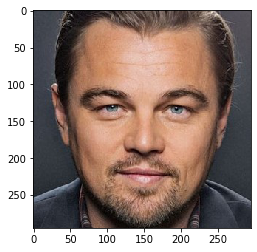

In [8]:
plt.imshow(Dicaprio)

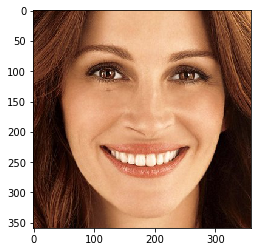

In [9]:
plt.imshow(Roberts)

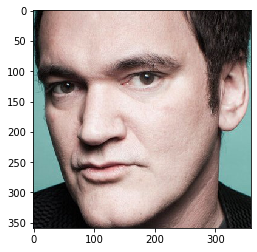

In [10]:
plt.imshow(Tarantino)

## Now, let's use the "is_person_in_video" function to see which celebrity is in the "Once upon a time in Hollywood" trailer:

In [11]:
is_person_in_video('once-upon-a-time-in-hollywood-teaser-1_h720p.mp4', Dicaprio)

1

In [14]:
is_person_in_video('once-upon-a-time-in-hollywood-teaser-1_h720p.mp4', Roberts)

0

In [15]:
is_person_in_video('once-upon-a-time-in-hollywood-teaser-1_h720p.mp4', Tarantino)

0

The function splits a video into frames, finds faces in some of the frames, compares them to the input person's portrait and outputs 1 if it was consitently finding faces similar to the input portrait.